In [2]:
import requests
import json
import pandas as pd
pd.set_option("display.precision", 9)
import numpy as np
import matplotlib as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,6)

import talib as ta

In [41]:
endpoint = 'https://ftx.com/api/'

futures = requests.get(endpoint + 'futures')

historical_prices_ALT = requests.get('https://ftx.com/api/futures/ALT-PERP/mark_candles?resolution=300')

historical_prices_EOS = requests.get('https://ftx.com/api/futures/EOS-PERP/mark_candles?resolution=300')
historical_prices_LEO = requests.get('https://ftx.com/api/futures/LEO-PERP/mark_candles?resolution=300')
historical_prices_LTC = requests.get('https://ftx.com/api/futures/LTC-PERP/mark_candles?resolution=300')
historical_prices_BCH = requests.get('https://ftx.com/api/futures/BCH-PERP/mark_candles?resolution=300')
historical_prices_TRX = requests.get('https://ftx.com/api/futures/TRX-PERP/mark_candles?resolution=300')
historical_prices_XRP = requests.get('https://ftx.com/api/futures/XRP-PERP/mark_candles?resolution=300')
historical_prices_BNB = requests.get('https://ftx.com/api/futures/BNB-PERP/mark_candles?resolution=300')
historical_prices_BSV = requests.get('https://ftx.com/api/futures/BSV-PERP/mark_candles?resolution=300')
historical_prices_ETH = requests.get('https://ftx.com/api/futures/ETH-PERP/mark_candles?resolution=300')



def convert_json_prices_to_df(_json_obj):

    hist_prices = json.loads(_json_obj.text).get('result')

    candles = []
    for i in range(0,len(hist_prices)):
        trade_row = []
        o = hist_prices[i].get('open')
        h = hist_prices[i].get('high')
        l = hist_prices[i].get('low')
        c = hist_prices[i].get('close')
        v = hist_prices[i].get('volume')
        ts= hist_prices[i].get('startTime')

        trade_row = [ts, o, h, l , c, v]
        candles.append(trade_row)

    hist_df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    return hist_df

ALT_df = convert_json_prices_to_df(historical_prices_ALT)
EOS_df = convert_json_prices_to_df(historical_prices_EOS)
BNB_df = convert_json_prices_to_df(historical_prices_BNB)
LTC_df = convert_json_prices_to_df(historical_prices_LTC)
BCH_df = convert_json_prices_to_df(historical_prices_BCH)
TRX_df = convert_json_prices_to_df(historical_prices_TRX)
XRP_df = convert_json_prices_to_df(historical_prices_XRP)
LEO_df = convert_json_prices_to_df(historical_prices_LEO)
BSV_df = convert_json_prices_to_df(historical_prices_BSV)
ETH_df = convert_json_prices_to_df(historical_prices_ETH)



eos_df = ALT_df.merge(EOS_df, how='outer', on='timestamp')
leo_df = ALT_df.merge(LEO_df, how='outer', on='timestamp')
trx_df = ALT_df.merge(TRX_df, how='outer', on='timestamp')
bch_df = ALT_df.merge(BCH_df, how='outer', on='timestamp')
xrp_df = ALT_df.merge(XRP_df, how='outer', on='timestamp')
ltc_df = ALT_df.merge(LTC_df, how='outer', on='timestamp')
bnb_df = ALT_df.merge(BNB_df, how='outer', on='timestamp')
bsv_df = ALT_df.merge(BSV_df, how='outer', on='timestamp')
eth_df = ALT_df.merge(ETH_df, how='outer', on='timestamp')


def add_ratio(df):
    
        df['ratio'] = df.close_x / df.close_y
        df['ratio_sma'] = df.ratio.rolling(168).mean()   #2016
        df['short_entry'] = df['ratio_sma'] * 1.02
        df['long_entry'] = df['ratio_sma'] * 0.98
        df['ratio_distance_from_ma'] = ((df.ratio - df.ratio_sma ) / df.ratio) * 100
        df['std_dev_of_ratio_dist'] = df['ratio_distance_from_ma'].rolling(2016).std()
        
        return df


eos_ready = add_ratio(eos_df)
leo_ready = add_ratio(leo_df)
bch_ready = add_ratio(bch_df)
trx_ready = add_ratio(trx_df)
xrp_ready = add_ratio(xrp_df)
ltc_ready = add_ratio(ltc_df)
bnb_ready = add_ratio(bnb_df)
bsv_ready = add_ratio(bsv_df)
eth_ready = add_ratio(eth_df)


eos_ratio = eos_ready.ratio_sma.iloc[-1]
leo_ratio = leo_ready.ratio_sma.iloc[-1]
bch_ratio = bch_ready.ratio_sma.iloc[-1]
trx_ratio = trx_ready.ratio_sma.iloc[-1]
xrp_ratio = xrp_ready.ratio_sma.iloc[-1]
ltc_ratio = ltc_ready.ratio_sma.iloc[-1]
bnb_ratio = bnb_ready.ratio_sma.iloc[-1]
bsv_ratio = bsv_ready.ratio_sma.iloc[-1]
eth_ratio = eth_ready.ratio_sma.iloc[-1]



futures = json.loads(futures.text).get('result')

futures_current = []

for f in futures:
    name = f.get('name')
    ask = f.get('ask')
    bid = f.get('bid')
    last = f.get('last')
    row = [name, last, ask, bid]
    futures_current.append(row)
    
futures_df = pd.DataFrame(futures_current, columns = ['name', 'last', 'ask', 'bid'])

futures_df['latest_AP_bid'] = futures_df.iloc[2].bid
futures_df['latest_AP_ask'] = futures_df.iloc[2].ask
futures_df['AP_bid_H_ask_ratio'] = futures_df.latest_AP_bid / futures_df.ask
futures_df['AP_ask_H_bid_ratio'] = futures_df.latest_AP_ask / futures_df.bid


futures_df = futures_df.drop([0, 1, 3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 22, 23, 25, 26, 27, 29])

futures_df['current_ratio_sma'] = 0


futures_df['current_ratio_sma'].iloc[0] = 1
futures_df['current_ratio_sma'].iloc[1] = bch_ratio
futures_df['current_ratio_sma'].iloc[2] = bnb_ratio
futures_df['current_ratio_sma'].iloc[3] = bsv_ratio
futures_df['current_ratio_sma'].iloc[4] = eos_ratio
futures_df['current_ratio_sma'].iloc[5] = eth_ratio
futures_df['current_ratio_sma'].iloc[6] = leo_ratio
futures_df['current_ratio_sma'].iloc[7] = ltc_ratio
futures_df['current_ratio_sma'].iloc[8] = 0
futures_df['current_ratio_sma'].iloc[9] = trx_ratio
futures_df['current_ratio_sma'].iloc[10] = xrp_ratio


futures_df['AP_bid_H_ask_pct_dist_from_ma_SHORT'] =  ((futures_df.AP_bid_H_ask_ratio - futures_df.current_ratio_sma) / futures_df.current_ratio_sma) * 100
futures_df['AP_ask_H_bid_pct_dist_from_ma_LONG'] =  ((futures_df.AP_ask_H_bid_ratio - futures_df.current_ratio_sma) / futures_df.current_ratio_sma) * 100


futures_df



/home/splinter/.local/lib/python3.5/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,name,last,ask,bid,latest_AP_bid,latest_AP_ask,AP_bid_H_ask_ratio,AP_ask_H_bid_ratio,current_ratio_sma,AP_bid_H_ask_pct_dist_from_ma_SHORT,AP_ask_H_bid_pct_dist_from_ma_LONG
2,ALT-PERP,689.9000000,697.900000,697.6000000,697.6,697.9,0.999570139,1.000430046,1.000000000,-0.042986101,0.043004587
4,BCH-PERP,345.3000000,344.800000,344.6500000,697.6,697.9,2.023201856,2.024952851,2.101461591,-3.724062111,-3.640739410
6,BNB-PERP,29.0725000,29.165000,29.1550000,697.6,697.9,23.919081090,23.937575030,23.471127683,1.908529548,1.987323971
8,BSV-PERP,139.2300000,141.380000,141.3300000,697.6,697.9,4.934219833,4.938088162,4.941777793,-0.152940103,-0.074662011
12,EOS-PERP,4.0325000,4.025000,4.0232500,697.6,697.9,173.316770186,173.466724663,173.438418303,-0.070139083,0.016320698
14,ETH-PERP,206.0000000,206.000000,205.9500000,697.6,697.9,3.386407767,3.388686574,3.354384193,0.954678167,1.022613361
16,LEO-PERP,1.2637000,1.245200,1.2448000,697.6,697.9,560.231288146,560.652313625,556.632128446,0.646595753,0.722233765
18,LTC-PERP,85.2700000,85.110000,85.0900000,697.6,697.9,8.196451651,8.201903866,8.246703914,-0.609361802,-0.543247925
20,MID-PERP,611.1000000,609.400000,609.2000000,697.6,697.9,1.144732524,1.145600788,0.000000000,inf,inf
24,TRX-PERP,0.0199575,0.020145,0.0200375,697.6,697.9,34628.940183668,34829.694323144,34472.445561455,0.453970177,1.036331354


In [42]:
# Simple backtester

def run_test(_df, _sl, _tp, _size, _trigger):
    
    position = 0
    
    trades_list = []
    
    current_trade = []
    
    opened_at_ratio = 0
    
    def open_short(_row):
        
        ts = row.timestamp
        long_x_price = _row.close_x
        short_y_price = _row.close_y
        ratio = _row.ratio
        ratio_ma = _row.ratio_sma
        ratio_dist = _row.ratio_distance_from_ma
       
        
        return [ts, long_x_price, short_y_price, ratio, ratio_ma, ratio_dist, -1]
    
    def close_short(_row):
        
        ts = row.timestamp
        long_x_price = _row.close_x
        short_y_price = _row.close_y
        ratio = _row.ratio
        ratio_ma = _row.ratio_sma
        ratio_dist = _row.ratio_distance_from_ma
        
        
        return [ts, long_x_price, short_y_price, ratio, ratio_ma, ratio_dist, 0]
    
    def open_long(_row):
        
        ts = row.timestamp
        long_y_price = _row.close_y
        short_x_price = _row.close_x
        ratio = _row.ratio
        ratio_ma = _row.ratio_sma
        ratio_dist = _row.ratio_distance_from_ma
       
        
        return [ts, short_x_price, long_y_price,  ratio, ratio_ma, ratio_dist, 1]
    
    def close_long(_row):
        
        ts = row.timestamp
        long_y_price = _row.close_y
        short_x_price = _row.close_x
        ratio = _row.ratio
        ratio_ma = _row.ratio_sma
        ratio_dist = _row.ratio_distance_from_ma
        
        
        return [ts, short_x_price, long_y_price,  ratio, ratio_ma, ratio_dist, 0]
    
    
    def ratio_stop(_row):
          
        ts = row.timestamp
        x_price = _row.close_x
        y_price = _row.close_y
        ratio = _row.ratio
        ratio_ma = _row.ratio_sma
        ratio_dist = _row.ratio_distance_from_ma
        
        return [ts, x_price, y_price,  ratio, ratio_ma, ratio_dist, 2]
    
    
    def ratio_tp(_row):
          
        ts = row.timestamp
        x_price = _row.close_x
        y_price = _row.close_y
        ratio = _row.ratio
        ratio_ma = _row.ratio_sma
        ratio_dist = _row.ratio_distance_from_ma
        
        return [ts, x_price, y_price,  ratio, ratio_ma, ratio_dist, 3]
    
    
    for index, row in _df.iterrows():
        
        
        if position == 0:
            
            if row.ratio_distance_from_ma > _trigger:
            
                trade_row = open_short(row)
                trades_list.append(trade_row)
                position = 1
                opened_at_ratio = row.ratio_distance_from_ma
                
            if row.ratio_distance_from_ma < -_trigger:
            
                trade_row = open_long(row)
                trades_list.append(trade_row)
                position = -1
                opened_at_ratio = row.ratio_distance_from_ma
                
        if position == 1:
            
            
            if row.ratio_distance_from_ma < 0.01: # Change this to a mutable variable later
                
                trade_row = close_short(row)
                trades_list.append(trade_row)
                position = 0
                
            if row.ratio_distance_from_ma > opened_at_ratio + _sl:
                trade_row = ratio_stop(row)
                trades_list.append(trade_row)
                position = 0
                
            if row.ratio_distance_from_ma < opened_at_ratio - _tp:
                trade_row = ratio_tp(row)
                trades_list.append(trade_row)
                position = 0
                
                
        if position == -1:
            
            if row.ratio_distance_from_ma > -0.01: # Change this to a mutable variable later
                
                trade_row = close_long(row)
                trades_list.append(trade_row)
                position = 0
                
            if row.ratio_distance_from_ma < opened_at_ratio - _sl:
                trade_row = ratio_stop(row)
                trades_list.append(trade_row)
                position = 0
                
            if row.ratio_distance_from_ma > opened_at_ratio + _tp:
                trade_row = ratio_tp(row)
                trades_list.append(trade_row)
                position = 0
                
        
    return trades_list
                
                
            
        
        
    

In [50]:
#tested_ltc = run_test(ltc_ready, 2, 1.01, 100, 4)
#tested_eos = run_test(eos_ready, 2, 1.01, 100, 4)
#tested_trx = run_test(trx_ready, 2, 1.01, 100, 4)
#tested_xrp = run_test(xrp_ready, 2, 1.01, 100, 3)
#tested_bch = run_test(bch_ready, 2, 1.01, 100, 4)
#tested_leo = run_test(leo_ready, 3, 1.01, 100, 4)
#tested_bnb = run_test(bnb_ready, 1, 4, 100, 8)

# def run_test(_df, _sl, _tp, _size, _trigger):

tested_ltc = run_test(ltc_ready, 1, 2, 100, 1.5)
tested_eos = run_test(eos_ready, 1, 2, 100, 1.5)
tested_trx = run_test(trx_ready, 1, 2, 100, 1.5)
tested_xrp = run_test(xrp_ready, 1, 2, 100, 1.5)
tested_bch = run_test(bch_ready, 1, 2, 100, 1.5)
tested_leo = run_test(leo_ready, 1, 2, 100, 1.5)
tested_bnb = run_test(bnb_ready, 1, 2, 100, 1.5)
tested_bsv = run_test(bsv_ready, 1, 2, 100, 1.5)
tested_eth = run_test(eth_ready, 1, 2, 100, 1.5)






In [51]:
ftx_fees = 0.0014
mex_fees = 0.0015

def analyse_result(_df):

    trades_df = pd.DataFrame(_df, columns =['timestamp', 'open_x', 'open_y','ratio', 'ratio_ma', 'ratio_dist', 'direction'])
    
    trades_df['position_x'] = np.where(trades_df.direction == -1, trades_df.direction * trades_df.open_x, 0 )
    trades_df['position_y'] = np.where(trades_df.direction == -1,(trades_df.ratio * -trades_df.direction) * trades_df.open_y, 0)
    
    trades_df['position_x'] = np.where(trades_df.direction == 1, (trades_df.open_x * trades_df.direction), trades_df.position_x)
    trades_df['position_y'] = np.where(trades_df.direction == 1, (trades_df.ratio * -trades_df.direction) * trades_df.open_y, trades_df.position_y)
    
      
    
    
    closing = (trades_df.direction == 0) | (trades_df.direction == 2) | (trades_df.direction == 3) 

    trades_df['pl_x'] = np.where(closing, ((trades_df.open_x.shift(1) - trades_df.open_x) / trades_df.open_x.shift(1) ) * -trades_df.position_x.shift(1), 0)
    trades_df['pl_y'] = np.where(closing, ((trades_df.open_y.shift(1) - trades_df.open_y) / trades_df.open_y.shift(1) ) * -trades_df.position_y.shift(1), 0)
    
    #stopped = trades_df.direction == 2
    
    #trades_df['pl_x'] = np.where(stopped, ((trades_df.open_x.shift(1) - trades_df.open_x) / trades_df.open_x.shift(1) ) * -trades_df.position_x.shift(1), trades_df.pl_x)
    #trades_df['pl_y'] = np.where(stopped, ((trades_df.open_y.shift(1) - trades_df.open_y) / trades_df.open_y.shift(1) ) * -trades_df.position_y.shift(1), trades_df.pl_y)
    
    
    
    trades_df['total_pl'] = trades_df['pl_x'] + trades_df['pl_y']
    trades_df['cum_pl'] = trades_df.total_pl.cumsum()

    trades_df['x_fees'] = abs(trades_df.position_x) * ftx_fees
    trades_df['y_fees'] = abs(trades_df.position_y) * mex_fees

    trades_df['pl_after_fees'] = trades_df.total_pl - (trades_df.x_fees.shift(1) + trades_df.y_fees.shift(1))

    trades_df['cum_pl_after_fees'] = trades_df['pl_after_fees'].cumsum()
    
    trades_df[['cum_pl', 'cum_pl_after_fees']].plot()
    
    return trades_df


,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-28T22:30:00+00:00,672.6,0.300000,2242.000000000,2288.740731456,-2.084778388,1,672.6,-672.6,0.0,0.000000000,0.000000000,0.000000000,0.94164,1.00890,NaN,NaN
1,2019-07-28T23:30:00+00:00,718.3,0.311425,2306.494340531,2287.070244903,0.842147986,0,0.0,0.0,45.7,-25.614850000,20.085150000,20.085150000,0.00000,0.00000,18.134610000,18.134610000
2,2019-07-28T23:30:00+00:00,718.3,0.311425,2306.494340531,2287.070244903,0.842147986,3,0.0,0.0,-0.0,-0.000000000,-0.000000000,20.085150000,0.00000,0.00000,-0.000000000,18.134610000
3,2019-07-30T11:00:00+00:00,707.2,0.316050,2237.620629647,2273.522267457,-1.604455971,1,707.2,-707.2,0.0,0.000000000,0.000000000,20.085150000,0.99008,1.06080,0.000000000,18.134610000
4,2019-07-30T15:15:00+00:00,723.7,0.320100,2260.855982505,2261.080494615,-0.009930403,0,0.0,0.0,16.5,-9.062363550,7.437636450,27.522786450,0.00000,0.00000,5.386756450,23.521366450
5,2019-08-03T02:15:00+00:00,746.5,0.314375,2374.552683897,2331.824785770,1.799408302,-1,-746.5,746.5,0.0,0.000000000,0.000000000,27.522786450,1.04510,1.11975,0.000000000,23.521366450
6,2019-08-03T09:30:00+00:00,736.6,0.314475,2342.316559345,2344.103255576,-0.076279025,0,0.0,0.0,9.9,0.237455268,10.137455268,37.660241718,0.00000,0.00000,7.972605268,31.493971718
7,2019-08-04T12:35:00+00:00,730.6,0.320100,2282.411746329,2324.279233529,-1.834352950,1,730.6,-730.6,0.0,0.000000000,0.000000000,37.660241718,1.02284,1.09590,0.000000000,31.493971718
8,2019-08-04T22:25:00+00:00,739.4,0.321250,2301.634241245,2301.117171512,0.022465330,0,0.0,0.0,8.8,-2.624773508,6.175226492,43.835468210,0.00000,0.00000,4.056486492,35.550458210
9,2019-08-05T00:45:00+00:00,749.1,0.320100,2340.206185567,2299.092629544,1.756834773,-1,-749.1,749.1,0.0,0.000000000,0.000000000,43.835468210,1.04874,1.12365,0.000000000,35.550458210


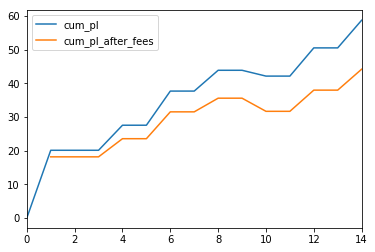

In [52]:
analyse_result(tested_xrp)


,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-31T12:05:00+00:00,728.0,94.22,7.726597325,7.861329839,-1.743749641,1,728.0,-728.0,0.0,0.000000000,0.000000000,0.000000000,1.01920,1.09200,NaN,NaN
1,2019-07-31T12:20:00+00:00,734.9,96.25,7.635324675,7.857364245,-2.908056689,2,0.0,0.0,6.9,-15.684992571,-8.784992571,-8.784992571,0.00000,0.00000,-10.896192571,-10.896192571
2,2019-07-31T12:25:00+00:00,734.1,95.66,7.674053941,7.856051350,-2.371594082,1,734.1,-734.1,0.0,0.000000000,0.000000000,-8.784992571,1.02774,1.10115,0.000000000,-10.896192571
3,2019-07-31T18:30:00+00:00,732.2,98.08,7.465334421,7.737585975,-3.646876866,2,0.0,0.0,-1.9,-18.571210537,-20.471210537,-29.256203108,0.00000,0.00000,-22.600100537,-33.496293108
4,2019-07-31T18:35:00+00:00,732.3,98.66,7.422460977,7.734855340,-4.208770703,1,732.3,-732.3,0.0,0.000000000,0.000000000,-29.256203108,1.02522,1.09845,0.000000000,-33.496293108
5,2019-07-31T22:35:00+00:00,732.8,98.28,7.456247456,7.616757254,-2.152688715,3,0.0,0.0,0.5,2.820535171,3.320535171,-25.935667937,0.00000,0.00000,1.196865171,-32.299427937
6,2019-07-31T22:40:00+00:00,733.7,98.57,7.443441209,7.614517889,-2.298354690,1,733.7,-733.7,0.0,0.000000000,0.000000000,-25.935667937,1.02718,1.10055,0.000000000,-32.299427937
7,2019-08-01T02:45:00+00:00,729.9,97.21,7.508486781,7.529710196,-0.282659012,3,0.0,0.0,-3.8,10.123080045,6.323080045,-19.612587892,0.00000,0.00000,4.195350045,-28.104077892
8,2019-08-01T12:20:00+00:00,729.0,98.88,7.372572816,7.486277828,-1.542270458,1,729.0,-729.0,0.0,0.000000000,0.000000000,-19.612587892,1.02060,1.09350,0.000000000,-28.104077892
9,2019-08-01T16:00:00+00:00,725.8,97.10,7.474768280,7.473785587,0.013146804,0,0.0,0.0,-3.2,13.123179612,9.923179612,-9.689408280,0.00000,0.00000,7.809079612,-20.294998280


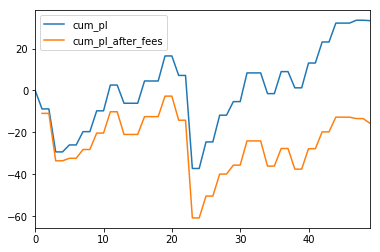

In [53]:
analyse_result(tested_ltc)

,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-28T12:35:00+00:00,708.0,0.0224650,31515.691075006,31991.374369758,-1.509353844,1,708.0,-708.0,0.0,0.000000000,0.000000000,0.000000000,0.99120,1.06200,NaN,NaN
1,2019-07-28T20:30:00+00:00,704.1,0.0222375,31662.731871838,31661.773688611,0.003026218,0,0.0,0.0,-3.9,7.169819720,3.269819720,3.269819720,0.00000,0.00000,1.216619720,1.216619720
2,2019-07-29T01:45:00+00:00,722.0,0.0224650,32138.882706432,31602.263864702,1.669687296,-1,-722.0,722.0,0.0,0.000000000,0.000000000,3.269819720,1.01080,1.08300,0.000000000,1.216619720
3,2019-07-29T09:15:00+00:00,706.6,0.0222250,31793.025871766,31866.619049622,-0.231475853,0,0.0,0.0,15.4,-7.713331850,7.686668150,10.956487870,0.00000,0.00000,5.592868150,6.809487870
4,2019-07-30T11:05:00+00:00,713.5,0.0217775,32763.172999656,32169.837950925,1.810981643,-1,-713.5,713.5,0.0,0.000000000,0.000000000,10.956487870,0.99890,1.07025,0.000000000,6.809487870
5,2019-07-30T11:40:00+00:00,711.0,0.0221225,32139.224771161,32168.552845475,-0.091253210,0,0.0,0.0,2.5,11.303294685,13.803294685,24.759782555,0.00000,0.00000,11.734144685,18.543632555
6,2019-08-01T19:15:00+00:00,733.9,0.0219200,33480.839416058,32942.603625950,1.607593476,-1,-733.9,733.9,0.0,0.000000000,0.000000000,24.759782555,1.02746,1.10085,0.000000000,18.543632555
7,2019-08-01T21:20:00+00:00,735.5,0.0222925,32993.159134238,32993.750702222,-0.001793002,0,0.0,0.0,-1.6,12.471612682,10.871612682,35.631395237,0.00000,0.00000,8.743302682,27.286935237
8,2019-08-02T09:20:00+00:00,737.1,0.0217075,33956.005988714,33362.891835245,1.746713538,-1,-737.1,737.1,0.0,0.000000000,0.000000000,35.631395237,1.03194,1.10565,0.000000000,27.286935237
9,2019-08-02T15:50:00+00:00,737.2,0.0219525,33581.596629086,33615.986333414,-0.102406400,0,0.0,0.0,-0.1,8.319221467,8.219221467,43.850616705,0.00000,0.00000,6.081631467,33.368566705


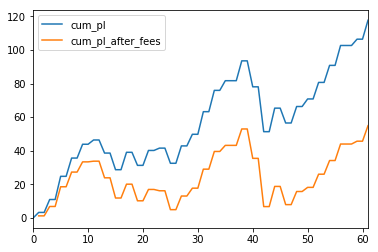

In [54]:
analyse_result(tested_trx)

,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-28T22:50:00+00:00,710.7,310.75,2.287047466,2.326345211,-1.718274134,1,710.7,-710.7,0.0,0.000000000,0.000000000,0.000000000,0.99498,1.06605,NaN,NaN
1,2019-07-29T08:00:00+00:00,714.5,308.95,2.312671953,2.312699529,-0.001192377,0,0.0,0.0,3.8,4.116685438,7.916685438,7.916685438,0.00000,0.00000,5.855655438,5.855655438
2,2019-07-30T11:05:00+00:00,713.5,316.35,2.255413308,2.300879390,-2.015864746,1,713.5,-713.5,0.0,0.000000000,0.000000000,7.916685438,0.99890,1.07025,0.000000000,5.855655438
3,2019-07-31T00:55:00+00:00,725.4,334.55,2.168285757,2.238699500,-3.247438352,2,0.0,0.0,11.9,-41.048522206,-29.148522206,-21.231836768,0.00000,0.00000,-31.217672206,-25.362016768
4,2019-07-31T01:00:00+00:00,723.9,333.15,2.172895092,2.238100129,-3.000836854,1,723.9,-723.9,0.0,0.000000000,0.000000000,-21.231836768,1.01346,1.08585,0.000000000,-25.362016768
5,2019-07-31T06:35:00+00:00,726.7,332.10,2.188196326,2.209962519,-0.994709319,3,0.0,0.0,2.8,2.281539847,5.081539847,-16.150296921,0.00000,0.00000,2.982229847,-22.379786921
6,2019-07-31T14:00:00+00:00,736.1,330.50,2.227231467,2.192668042,1.551856014,-1,-736.1,736.1,0.0,0.000000000,0.000000000,-16.150296921,1.03054,1.10415,0.000000000,-22.379786921
7,2019-07-31T16:25:00+00:00,730.8,323.75,2.257297297,2.198297541,2.613734436,2,0.0,0.0,5.3,-15.033812405,-9.733812405,-25.884109326,0.00000,0.00000,-11.868502405,-34.248289326
8,2019-07-31T16:30:00+00:00,732.1,324.30,2.257477644,2.198734483,2.602159160,-1,-732.1,732.1,0.0,0.000000000,0.000000000,-25.884109326,1.02494,1.09815,0.000000000,-34.248289326
9,2019-08-01T02:40:00+00:00,730.3,323.65,2.256449869,2.243680791,0.565892382,3,0.0,0.0,1.8,-1.467360469,0.332639531,-25.551469795,0.00000,0.00000,-1.790450469,-36.038739795


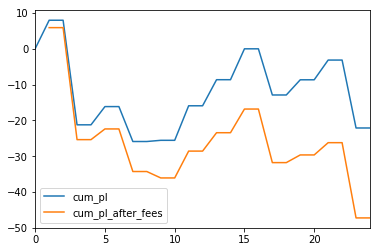

In [55]:
analyse_result(tested_bch)

,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-28T22:30:00+00:00,672.6,3.89450,172.705096932,165.672330793,4.072124253,-1,-672.6,672.6,0.0,0.000000000,0.000000000,0.000000000,0.94164,1.00890,NaN,NaN
1,2019-07-28T22:55:00+00:00,701.5,4.16375,168.477934554,165.826793446,1.573583576,3,0.0,0.0,-28.9,46.500847349,17.600847349,17.600847349,0.00000,0.00000,15.650307349,15.650307349
2,2019-07-28T23:00:00+00:00,700.9,4.13600,169.463249516,165.850645317,2.131792120,-1,-700.9,700.9,0.0,0.000000000,0.000000000,17.600847349,0.98126,1.05135,0.000000000,15.650307349
3,2019-07-29T01:45:00+00:00,722.0,4.34225,166.273245437,166.104416673,0.101536939,3,0.0,0.0,-21.1,34.951795213,13.851795213,31.452642562,0.00000,0.00000,11.819185213,27.469492562
4,2019-07-31T23:00:00+00:00,736.5,4.40525,167.186879292,169.807331418,-1.567379053,1,736.5,-736.5,0.0,0.000000000,0.000000000,31.452642562,1.03110,1.10475,0.000000000,27.469492562
5,2019-08-01T05:35:00+00:00,722.4,4.21900,171.225408865,168.295613870,1.711074901,0,0.0,0.0,-14.1,31.138556268,17.038556268,48.491198830,0.00000,0.00000,14.902706268,42.372198830
6,2019-08-01T05:35:00+00:00,722.4,4.21900,171.225408865,168.295613870,1.711074901,3,0.0,0.0,-0.0,-0.000000000,-0.000000000,48.491198830,0.00000,0.00000,-0.000000000,42.372198830
7,2019-08-02T16:40:00+00:00,720.3,4.08050,176.522484990,171.259084838,2.981716551,-1,-720.3,720.3,0.0,0.000000000,0.000000000,48.491198830,1.00842,1.08045,0.000000000,42.372198830
8,2019-08-02T21:35:00+00:00,722.2,4.14875,174.076529075,172.517635766,0.895521825,3,0.0,0.0,-1.9,12.047659601,10.147659601,58.638858430,0.00000,0.00000,8.058789601,50.430988430
9,2019-08-03T01:50:00+00:00,734.4,4.30775,170.483431025,173.099441808,-1.534466292,1,734.4,-734.4,0.0,0.000000000,0.000000000,58.638858430,1.02816,1.10160,0.000000000,50.430988430


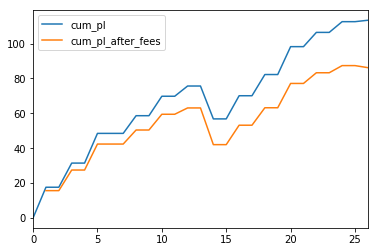

In [56]:
analyse_result(tested_eos)

,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-28T22:25:00+00:00,677.1,1.2525,540.598802395,554.494904099,-2.570501755,1,677.1,-677.1,0.0,0.000000000,0.000000000,0.000000000,0.94794,1.01565,NaN,NaN
1,2019-07-28T22:50:00+00:00,710.7,1.2749,557.455486705,554.188410849,0.586069370,0,0.0,0.0,33.6,-12.109413174,21.490586826,21.490586826,0.00000,0.00000,19.526996826,19.526996826
2,2019-07-28T22:50:00+00:00,710.7,1.2749,557.455486705,554.188410849,0.586069370,3,0.0,0.0,-0.0,-0.000000000,-0.000000000,21.490586826,0.00000,0.00000,-0.000000000,19.526996826
3,2019-07-29T06:55:00+00:00,712.5,1.3106,543.644132458,552.138611081,-1.562507183,1,712.5,-712.5,0.0,0.000000000,0.000000000,21.490586826,0.99750,1.06875,0.000000000,19.526996826
4,2019-07-29T12:35:00+00:00,703.0,1.2790,549.648162627,547.924518593,0.313590430,0,0.0,0.0,-9.5,17.179154586,7.679154586,29.169741412,0.00000,0.00000,5.612904586,25.139901412
5,2019-07-29T13:00:00+00:00,709.5,1.2737,557.038549109,548.125633295,1.600053682,-1,-709.5,709.5,0.0,0.000000000,0.000000000,29.169741412,0.99330,1.06425,0.000000000,25.139901412
6,2019-07-29T14:20:00+00:00,706.2,1.2961,544.865365327,547.921825654,-0.560956985,0,0.0,0.0,3.3,12.477663500,15.777663500,44.947404912,0.00000,0.00000,13.720113500,38.860014912
7,2019-07-29T14:20:00+00:00,706.2,1.2961,544.865365327,547.921825654,-0.560956985,3,0.0,0.0,-0.0,-0.000000000,-0.000000000,44.947404912,0.00000,0.00000,-0.000000000,38.860014912
8,2019-07-29T19:55:00+00:00,703.9,1.3237,531.767016696,545.140423276,-2.514899601,1,703.9,-703.9,0.0,0.000000000,0.000000000,44.947404912,0.98546,1.05585,0.000000000,38.860014912
9,2019-07-30T02:00:00+00:00,700.3,1.3522,517.896760834,537.022007163,-3.692868497,2,0.0,0.0,-3.6,-15.155359976,-18.755359976,26.192044936,0.00000,0.00000,-20.796669976,18.063344936


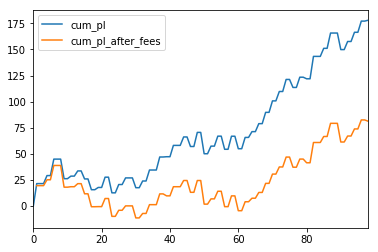

In [57]:
analyse_result(tested_leo)

,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-31T02:45:00+00:00,720.4,27.4650,26.229746951,26.631402454,-1.531297669,1,720.4,-720.4,0.0,0.000000000,0.000000000,0.000000000,1.00856,1.08060,NaN,NaN
1,2019-07-31T12:20:00+00:00,734.9,27.6425,26.585873202,26.390381652,0.735321156,0,0.0,0.0,14.5,-4.655780084,9.844219916,9.844219916,0.00000,0.00000,7.755059916,7.755059916
2,2019-07-31T12:20:00+00:00,734.9,27.6425,26.585873202,26.390381652,0.735321156,3,0.0,0.0,-0.0,-0.000000000,-0.000000000,9.844219916,0.00000,0.00000,-0.000000000,7.755059916
3,2019-08-01T05:35:00+00:00,722.4,27.7700,26.013683831,26.496641113,-1.856550899,1,722.4,-722.4,0.0,0.000000000,0.000000000,9.844219916,1.01136,1.08360,0.000000000,7.755059916
4,2019-08-01T09:10:00+00:00,723.4,28.2475,25.609345960,26.353362279,-2.905253108,2,0.0,0.0,1.0,-12.421534030,-11.421534030,-1.577314113,0.00000,0.00000,-13.516494030,-5.761434113
5,2019-08-01T09:15:00+00:00,723.2,28.3200,25.536723164,26.347326932,-3.174266967,1,723.2,-723.2,0.0,0.000000000,0.000000000,-1.577314113,1.01248,1.08480,0.000000000,-5.761434113
6,2019-08-01T09:40:00+00:00,724.2,28.6700,25.259853505,26.314825722,-4.176477970,2,0.0,0.0,1.0,-8.937853107,-7.937853107,-9.515167221,0.00000,0.00000,-10.035133107,-15.796567221
7,2019-08-01T09:45:00+00:00,723.4,28.5150,25.369103980,26.307801038,-3.700158500,1,723.4,-723.4,0.0,0.000000000,0.000000000,-9.515167221,1.01276,1.08510,0.000000000,-15.796567221
8,2019-08-01T10:00:00+00:00,721.5,27.2975,26.430991849,26.292654408,0.523391031,0,0.0,0.0,-1.9,30.886884096,28.986884096,19.471716875,0.00000,0.00000,26.889024096,11.092456875
9,2019-08-01T10:00:00+00:00,721.5,27.2975,26.430991849,26.292654408,0.523391031,3,0.0,0.0,-0.0,-0.000000000,-0.000000000,19.471716875,0.00000,0.00000,-0.000000000,11.092456875


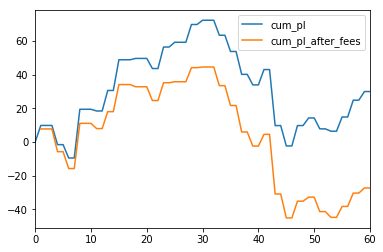

In [58]:
analyse_result(tested_bnb)

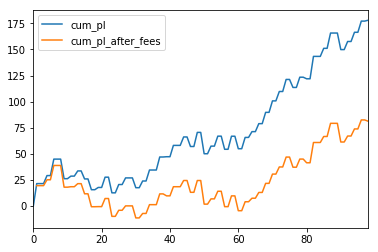

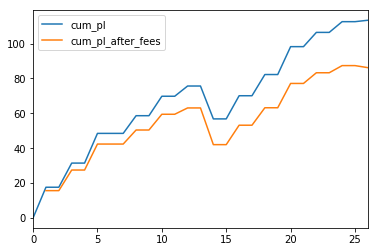

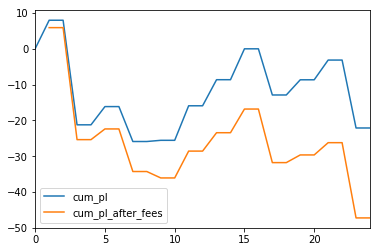

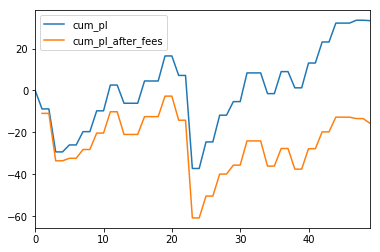

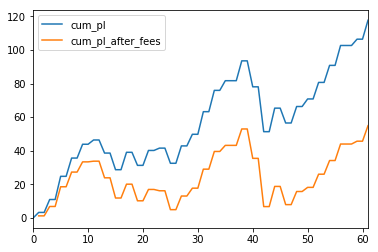

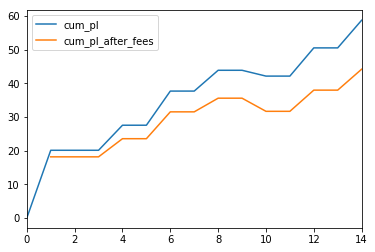

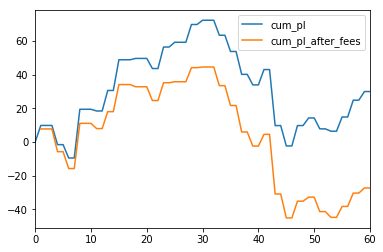

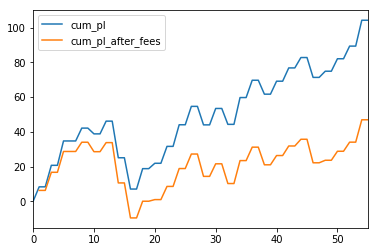

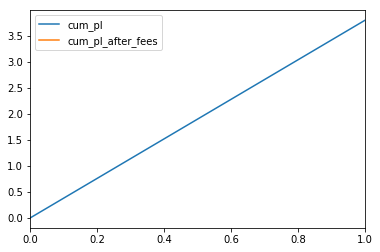

In [59]:
leo_result = analyse_result(tested_leo)
eos_result = analyse_result(tested_eos)
bch_result = analyse_result(tested_bch)
ltc_result = analyse_result(tested_ltc)
trx_result = analyse_result(tested_trx)
xrp_result = analyse_result(tested_xrp)
bnb_result = analyse_result(tested_bnb)
bsv_result = analyse_result(tested_bsv)
eth_result = analyse_result(tested_eth)






,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-07-28T13:45:00+00:00,705.0,145.75,4.837049743,4.747248297,1.856533428,-1,-705.0,705.0,0.0,0.000000000,0.000000000,0.000000000,0.98700,1.05750,NaN,NaN
1,2019-07-28T20:00:00+00:00,707.0,147.89,4.780580161,4.780470198,0.002300198,0,0.0,0.0,-2.0,10.351286449,8.351286449,8.351286449,0.00000,0.00000,6.306786449,6.306786449
2,2019-07-28T22:40:00+00:00,677.3,138.13,4.903351915,4.786054967,2.392178856,-1,-677.3,677.3,0.0,0.000000000,0.000000000,8.351286449,0.94822,1.01595,0.000000000,6.306786449
3,2019-07-29T01:35:00+00:00,721.6,149.69,4.820629301,4.806580940,0.291421722,3,0.0,0.0,-44.3,56.682748136,12.382748136,20.734034585,0.00000,0.00000,10.418578136,16.725364585
4,2019-07-30T01:30:00+00:00,702.2,142.83,4.916334103,4.823207888,1.894220636,-1,-702.2,702.2,0.0,0.000000000,0.000000000,20.734034585,0.98308,1.05330,0.000000000,16.725364585
5,2019-07-30T05:30:00+00:00,699.0,145.03,4.819692477,4.845278630,-0.530866917,0,0.0,0.0,3.2,10.815935028,14.015935028,34.749969613,0.00000,0.00000,11.979555028,28.704919613
6,2019-07-30T05:30:00+00:00,699.0,145.03,4.819692477,4.845278630,-0.530866917,3,0.0,0.0,-0.0,-0.000000000,-0.000000000,34.749969613,0.00000,0.00000,-0.000000000,28.704919613
7,2019-07-30T15:05:00+00:00,714.9,149.96,4.767271272,4.839374325,-1.512459619,1,714.9,-714.9,0.0,0.000000000,0.000000000,34.749969613,1.00086,1.07235,0.000000000,28.704919613
8,2019-07-30T18:55:00+00:00,719.1,149.29,4.816799518,4.815199646,0.033214409,0,0.0,0.0,4.2,3.194071752,7.394071752,42.144041365,0.00000,0.00000,5.320861752,34.025781365
9,2019-07-31T12:30:00+00:00,735.7,148.76,4.945549879,4.870690302,1.513675499,-1,-735.7,735.7,0.0,0.000000000,0.000000000,42.144041365,1.02998,1.10355,0.000000000,34.025781365


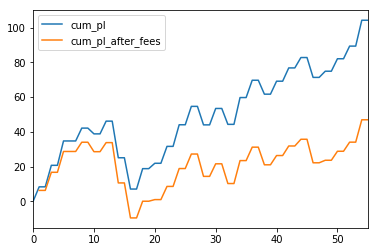

In [60]:
analyse_result(tested_bsv)

,timestamp,open_x,open_y,ratio,ratio_ma,ratio_dist,direction,position_x,position_y,pl_x,pl_y,total_pl,cum_pl,x_fees,y_fees,pl_after_fees,cum_pl_after_fees
0,2019-08-08T18:00:00+00:00,719.9,215.97,3.333333333,3.275565107,1.733046784,-1,-719.9,719.9,0.0,0.0,0.0,0.0,1.00786,1.07985,NaN,NaN
1,2019-08-09T08:20:00+00:00,721.9,217.71,3.315878922,3.320316899,-0.133840152,0,0.0,0.0,-2.0,5.8,3.8,3.8,0.00000,0.00000,1.71229,1.71229


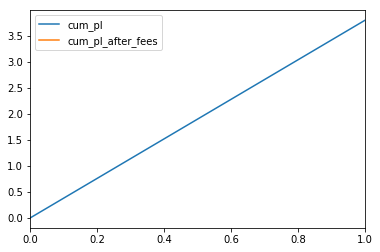

In [61]:
analyse_result(tested_eth)

In [62]:
whole_pl = leo_result.cum_pl_after_fees.iloc[-1] + eos_result.cum_pl_after_fees.iloc[-1] \
+ ltc_result.cum_pl_after_fees.iloc[-1] + xrp_result.cum_pl_after_fees.iloc[-1] + \
bch_result.cum_pl_after_fees.iloc[-1] + trx_result.cum_pl_after_fees.iloc[-1] \
 + bnb_result.cum_pl_after_fees.iloc[-1] + eth_result.cum_pl_after_fees.iloc[-1] \
+ bsv_result.cum_pl_after_fees.iloc[-1]



whole_pl

224.97685542107095